# Part 2 of "Unpaired image to image translation​ using cycleGAN in keras": Train a cycleGAN model

1) Link to the Youtube video tutorial: https://www.youtube.com/watch?v=2MSGnkir9ew&list=PLZsOBAyNTZwboR4_xj-n3K6XBTweC4YVD&index=10
2) Link to the dataset (horse2zebrea): https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset?resource=download

3) Instruction: 
    1) This is the main script of this tutorial. This script only load the dataset you want, then train the GAN model by importing the functions you defined in the supplementary script. 
    2) Run this script to train the GAN model (cycleGAN). Here, we train the cycleGAN to receive each real domain A image (horse image) and generate its version of fake domain B image (zebra image), and vice versa.
    3) Use the virtual environment called GPUEnv to run this script. This virtual environemnt uses Python 3.7.16 version, Tensorflow 2.6.0 version, Keras 2.6.0 version.

4) Definition in this tutorial:
    1) Each domain A image is a horse image.
    2) Each domain B image is a zebra image.

In [7]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np

# Define a function to load all images of a particular domain that located in a directory into memory

1) Here, take note that:
    1) Each domain A image is a horse image. The dataset A stores all real domain A images.
    2) Each domain B image is a zebra image. The dataset B stores all real domain B images.

In [8]:
# Load all images of a particular domain that located in a directory into memory
def load_images(path, size=(256,256)): # path refers to the directory that stores the images of a particular domain; size refers to the dimension of each sample (image) in that directory
	data_list = list() # Create an empty list, called data_list (the variable that stores all pixels [features] of all images of a particular domain located in the directory called path)
	# Enumerate filenames in directory, assume all are images. However, take note that when we open an image file (load an image into memory), we get the pixel values (features) of that image.
	for filename in listdir(path): # listdir(path) return a list containing the names (filename) of the entries (files/directories) in the directory called path. In other words, path is the folder that stores images (a list of names). Hence, the variable filename contains a filename (image) at each iteration.
		# Load and resize the image
		pixels = load_img(path + filename, target_size=size) # load_img() loads an image whose directory = (path + filename) in the required size of target_size into PIL format. The loaded image is stored in the variable pixels. This means at each iteration, the variable pixels contains all the pixel values (features) of a loaded image as a PIL image class object in the dimension of target_size.
		# Convert all the pixel values (features) of a loaded image from a PIL image class object into a numpy array (vector)
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels) # Concatenate all the pixels [features] of current image right after the ones of previous image in the variable data_list.
	return asarray(data_list) # Returns all pixels [features] of all images of a particular domain located in the directory called path as an array.

# Load the dataset images

1) Since the number of real domain A images and real domain B images available in the dataset are not the same, the important issue of data imbalance occurs. 
2) To solve the issue of data imbalance, we use resampling method:
    1) Randomly select only 500 real domain A images from the original dataset A (dataA_all), then save them as a new dataset A (dataA). 
    1) Randomly select only 500 real domain B images from the original dataset B (dataB_all), then save them as a new dataset B (dataB).
    3) Only the samples in dataA and dataB will be used for training.
3) The simplest strategy is to choose examples for the transformed dataset randomly, called random resampling
    1) Reference: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

Loaded dataA:  (1067, 256, 256, 3)
Loaded dataB:  (1334, 256, 256, 3)


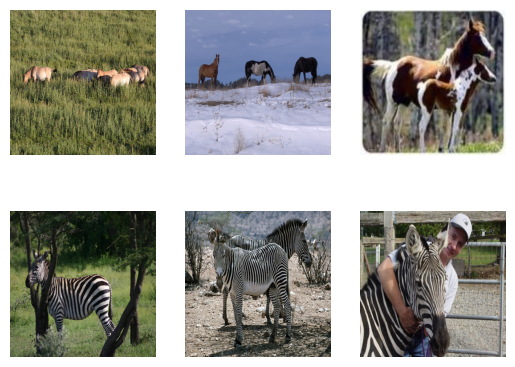

Loaded (500, 256, 256, 3) (500, 256, 256, 3)


In [9]:
# The relative path to the train set images of the dataset
path = 'data/horse2zebra/' 

# Load dataset A - real horse images
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
# Get a subset of all real domain A images, for faster training during demonstration
# dataA stores n_samples numbers of randomly selected real domain A images
dataA = resample(dataA_all, # the original dataset whose samples will be randomly chosen
                 replace=False,     
                 n_samples=500, # the number of samples will be randomly chosen from the original dataset   
                 random_state=42) # for reproducibility

# Load dataset B - real zebra images 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
# Get a subset of all real domain B images, for faster training during demonstration
# We could have just read the list of files and only load a subset, better memory management. 
# dataB stores n_samples numbers of randomly selected real domain B images
dataB = resample(dataB_all, # the original dataset whose samples will be randomly chosen
                 replace=False,     
                 n_samples=500, # the number of samples will be randomly chosen from the original dataset    
                 random_state=42) # for reproducibility

# The codes below are just for the purpose of train set images visualization only
n_samples = 3 # The number of train set images to visualize

# Plot the first 3 real domain A images on the first row of a 2x(n_samples) subplot
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# Plot the first 3 real domain B images on the second row of a 2x(n_samples) subplot 
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))

# Show that 2x(n_samples) subplot 
plt.show()

# Define the variable data that stores the pixel values (features) of real domain A images and pixel values (features) of real domain B images respectively (as separate dimension) for training
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

# Define a function to scale the pixel values from [0,255] to [-1,1]

In [10]:
# Preprocess data to change each input pixel value into value between -1 and 1
# This is because the generator uses tanh activation in the output layer
# And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1] # Load the pixel values of real domain A images into the variable X1, load the pixel values of real domain B images into the variable X2
	# Scale all pixel values from [0,255] to [-1,1] (because we use Tanh activation function (provides a value in the range from -1 to 1) at the output layer of the generator network)
	X1 = (X1 - 127.5) / 127.5 # Scale the pixel values of real domain A images
	X2 = (X2 - 127.5) / 127.5 # Scale the pixel values of real domain B images
	return [X1, X2] # Return the scaled pixel values of real domain A images and pixel values of real domain B images respectively

dataset = preprocess_data(data) # Scale the pixel values of real domain A images and real domain B images from [0,255] to [-1,1], then store them in the variable dataset (as separate dimension) respectively

# Create generator, discriminator, and GAN models respectively

In [11]:
from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train # import the defined functions called (define_generator, define_discriminator, define_composite_model, train) from the python (.py) file called cycleGAN_model located in the same folder. If you want to use this import defined functions feature, the functions must be defined in a .py file (cannot in a .ipynb file).
# Define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:] # Since dataset[0].shape=(500, 256, 256, 3), dataset[0].shape[1:]=(256, 256, 3) which also means the shape of each real domain A image

# generator: A -> B
g_model_AtoB = define_generator(image_shape) # Define/create the generator that takes each real domain A image to generate a fake domain B image
# generator: B -> A
g_model_BtoA = define_generator(image_shape) # Define/create the generator that takes each real domain B image to generate a fake domain A image
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape) # Define/create the discriminator that takes each real or fake domain A image to provide a probability score of the given domain A image as a real image
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape) # Define/create the discriminator that takes each real or fake domain B image to provide a probability score of the given domain B image as a real image
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape) # Define/create the composite model which will be called to train the generator that takes real domain B images to generate fake domain A images, using the created generator model, created discriminator model, and image_shape
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape) # Define/create the composite model which will be called to train the generator that takes real domain A images to generate fake domain B images, using the created generator model, created discriminator model, and image_shape

# Train the GAN model (cycleGAN)

In [12]:
from datetime import datetime 
start1 = datetime.now() # gets the current local date and time as the GAN model training start date and time

# Train the GAN model 
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5)
    # d_model_A refers to the built discriminator network that takes each real or fake domain A image to provide a probability score of the given domain A image as a real image
    # d_model_B refers to the built discriminator network that takes each real or fake domain B image to provide a probability score of the given domain B image as a real image
    # g_model_AtoB refers to the built generator that takes each real domain A image to generate a fake domain B image
    # g_model_BtoA refers to the built generator that takes each real domain B image to generate a fake domain A image
    # c_model_AtoB refers to the built composite model (cycleGAN) which will be called to train the generator that takes real domain A images to generate fake domain B images
    # c_model_BtoA refers to the built composite model (cycleGAN) which will be called to train the generator that takes real domain B images to generate fake domain A images
    # dataset refers to the scaled real domain A images and real domain B images, which will be used for training
    # n_epochs refers to the number of epochs for the GAN model training
    # n_batch refers to the number of sample in each batch

stop1 = datetime.now() # gets the current local date and time as the GAN model training end date and time
execution_time = stop1-start1 # Calculate the GAN model training duration (Execution time of the model)
print("Execution time is: ", execution_time)


ResourceExhaustedError:  failed to allocate memory
	 [[node gradient_tape/model_11/model_7/instance_normalization_80/truediv/Neg (defined at d:\AI_Master_New\Under_Local_Git_Covered\Deep_Learning_Tutorials_codebasics\Generative_Adversarial_Network_GAN\cycleGAN_Unpaired_ImageTranslation_Keras_Tutorial9\cycleGAN_model.py:284) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_80127]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/model_11/model_7/instance_normalization_80/truediv/Neg:
 model_11/model_7/instance_normalization_80/sub (defined at d:\AI_Master_New\Under_Local_Git_Covered\Deep_Learning_Tutorials_codebasics\Generative_Adversarial_Network_GAN\cycleGAN_Unpaired_ImageTranslation_Keras_Tutorial9\instancenormalization.py:119)

Function call stack:
train_function


# Deploy the trained generator networks to generate images

## Define supplementary functions

In [ ]:
# Use the saved cyclegan models for image translation
from instancenormalization import InstanceNormalization  
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# Select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# Choose random instances
	ix = randint(0, dataset.shape[0], n_samples) # Select n_samples numbers of real images of a particular domain the variable dataset contains, by randomly generating n_samples numbers of integers between the range from 0 (low) to dataset.shape[0] (high). Each randomly generated interger by the function represents the index of the image/sample in the variable dataset. The randomly generated indices for the real images (images in the variable dataset) are stored in the variable ix. Since each integer is randomly generated between the given range, it is possible to have multiple same integer (index of an image/sample) in ix, so that it is possible to use multiple same real images for visualization.
	# Retrieve selected images
	X = dataset[ix] # Load the features of the real images of a particular domain the variable dataset contains, whose indices are available in the variable ix, into the variable X. In other words, the variable X stores the features of a set of chosen real images that will be used for visualization.
	return X

# Plot the selected images for visualization, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

## Load all the trained generator models

In [ ]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization} # Since we use InstanceNormalization here, we must mention the InstanceNormalization function that imported from another py file and used for training
model_AtoB = load_model('g_model_AtoB_005935.h5', cust) # Since we use InstanceNormalization here, we must mention the InstanceNormalization function that imported from another py file and used for training, right after the generator model filename
model_BtoA = load_model('g_model_BtoA_005935.h5', cust) # Since we use InstanceNormalization here, we must mention the InstanceNormalization function that imported from another py file and used for training, right after the generator model filename

## Using the image involved in the training

### Data preprocessing

In [ ]:
# Load dataset
# The dataset A_data contains a small subset of real domain A images from its original dataset (dataA_all)
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

# The dataset B_data contains a small subset of real domain B images from its original dataset (dataB_all)
B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

# Scale all pixel values from [0,255] to [-1,1] (because we use Tanh activation function (provides a value in the range from -1 to 1) at the output layer of the generator network)
A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

### Show the forward cycle consistency performance

In [ ]:
# plot A->B->A (Horse to zebra to horse)
A_real = select_sample(A_data, 1) # Randomly select a real domain A image from the specified dataset
B_generated  = model_AtoB.predict(A_real) # Deploy the trained generator model called model_AtoB to take that randomly selected real domain A image, and then generate a fake domain B image
A_reconstructed = model_BtoA.predict(B_generated) # Deploy the trained generator model called model_BtoA to take that generated fake domain B image, and then generate a fake domain A image (this generated fake domain A image should look same as the real domain A image which is fed into the trained generator called model_AtoB)
show_plot(A_real, B_generated, A_reconstructed) # Show the 3 images side-by-side

### Show the backward cycle consistency performance

In [ ]:
# plot B->A->B (Zebra to horse to zebra)
B_real = select_sample(B_data, 1) # Randomly select a real domain B image from the specified dataset
A_generated  = model_BtoA.predict(B_real) # Deploy the trained generator model called model_BtoA to take that randomly selected real domain B image, and then generate a fake domain A image
B_reconstructed = model_AtoB.predict(A_generated) # Deploy the trained generator model called model_AtoB to take that generated fake domain A image, and then generate a fake domain B image (this generated fake domain B image should look same as the real domain B image which is fed into the trained generator called model_BtoA)
show_plot(B_real, A_generated, B_reconstructed) # Show the 3 images side-by-side


## Using the image which is not involved in the training

In [ ]:
from PIL import Image
# Define a function to resize the input custom image into the dimension the generator and discriminator networks can accept
def resize_image(input_path, output_path, width, height):
    with Image.open(input_path) as img:
        resized_img = img.resize((width, height), Image.ANTIALIAS)
        resized_img.save(output_path)
        print(f"Image saved to {output_path}")


# Path of the input custom domain B image
subfolder = 'data/'
custom_image_name = 'cartoon-cute-baby-zebra-sitting-vector'
custom_image_extension = '.jpg'
custom_image_path = subfolder + custom_image_name + custom_image_extension # the input custom domain B image
resized_custom_image_path = subfolder + custom_image_name + '_resized' + custom_image_extension # the resized input custom domain B image

# Resize the input custom image into the dimension the generator and discriminator networks can accept
resize_image(custom_image_path, resized_custom_image_path, image_shape[0], image_shape[1])

# Load the resized input custom domain B image
test_image = load_img(resized_custom_image_path) # the resized input custom domain B image

test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5 # Scale each pixel value into the range from -1 to 1

# plot B->A->B (Zebra to horse to zebra)
photo_generated  = model_BtoA.predict(test_image_input) # Deploy the trained generator model called model_BtoA to take that input custom domain B image, and then generate a fake domain A image
photo_reconstructed = model_AtoB.predict(photo_generated) # Deploy the trained generator model called model_AtoB to take that generated fake domain A image, and then generate a fake domain B image (this generated fake domain B image should look same as the input custom domain B image which is fed into the trained generator called model_BtoA)
show_plot(test_image_input, photo_generated, photo_reconstructed) # Show the 3 images side-by-side